In [17]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt


sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

### Settings

In [18]:
BASE_PATH = "../notebooks/dataframes/"
SPEED_BENCH_PATH = "/home/emerge/gpudrive/examples/benchmarks/results/"
WINDOW = 10
ALPHA = 0.25
MARKERSIZE = 12

# COLORS
GPUDRIVE_COLOR = "magenta"
NOCTURNE_COLOR = "#2952a3"
NOCTURNE_PUFFERLIB_COLOR = "#5983d5"
WAYMAX_COLOR = "#339966"
OPTIM_PERF_COLOR = "#40bf80"

## Performance vs. global step and wallclock time 

- GPUDrive is X times faster than Nocturne -- Ceteris paribus 

In [19]:
df_goal_wallclock = pd.read_csv(f"{BASE_PATH}wallclock_vs_perc_goal_achieved.csv")

df_goal_wallclock = df_goal_wallclock[[
    "metrics/wallclock_time (s)", 
    "BEST_nocturne_07_08_12_31 - metrics/perc_goal_achieved",
    "BEST_gpudrive_07_08_11_35 - metrics/perc_goal_achieved",
    ]
]

df_goal_wallclock.columns = [
    "Wallclock time (s)",
    "nocturne",
    "gpudrive",
]

df_goal_wallclock['nocturne_smooth'] = df_goal_wallclock['nocturne'].rolling(window=WINDOW).mean()
df_goal_wallclock['gpudrive_smooth'] = df_goal_wallclock['gpudrive'].rolling(window=WINDOW).mean()

df_goal_step = pd.read_csv(f"{BASE_PATH}globalstep_vs_perc_goal_achieved.csv")
df_goal_step = df_goal_step[[
    "global_step", 
    "BEST_nocturne_07_08_12_31 - metrics/perc_goal_achieved",
    "BEST_gpudrive_07_08_11_35 - metrics/perc_goal_achieved",
    ]
]
df_goal_step.columns = [
    "Global step",
    "nocturne",
    "gpudrive",
]

df_goal_step['nocturne_smooth'] = df_goal_step['nocturne'].rolling(window=WINDOW).mean()
df_goal_step['gpudrive_smooth'] = df_goal_step['gpudrive'].rolling(window=WINDOW).mean()

df_goal_wallclock['Wallclock time (min)'] = df_goal_wallclock['Wallclock time (s)'] / 60

data = {
    "Wallclock time (s)": [39000, 970],
    "Simulator": ["Nocturne", "GPUDrive"]
}

# Create the dataframe
df_to_95 = pd.DataFrame(data)

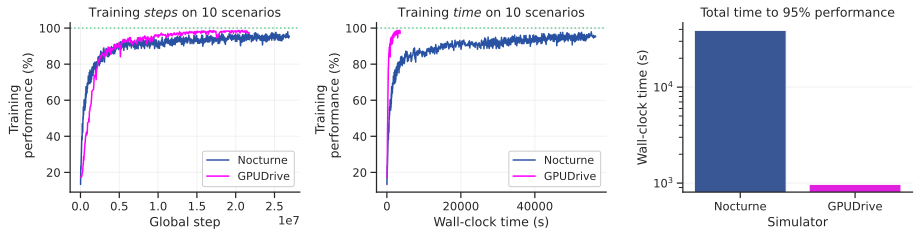

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3.5), sharex=False)

axs[0].set_title(r'Training $steps$ on 10 scenarios')
sns.lineplot(data=df_goal_step, x='Global step', y='nocturne', color=NOCTURNE_COLOR, label='Nocturne', ax=axs[0])
sns.lineplot(data=df_goal_step, x='Global step', y='gpudrive', color=GPUDRIVE_COLOR, label='GPUDrive', ax=axs[0])

axs[1].set_title(r'Training $time$ on 10 scenarios')
sns.lineplot(data=df_goal_wallclock, x='Wallclock time (s)', y='nocturne', color=NOCTURNE_COLOR, label='Nocturne', ax=axs[1])
sns.lineplot(data=df_goal_wallclock, x='Wallclock time (s)', y='gpudrive', color=GPUDRIVE_COLOR, label='GPUDrive', ax=axs[1])

# add horizontal line at 100
axs[0].axhline(y=100, color=OPTIM_PERF_COLOR, linestyle='dotted', alpha=0.8)
axs[1].axhline(y=100, color=OPTIM_PERF_COLOR, linestyle='dotted', alpha=0.8)

axs[0].set_xlabel('Global step')
axs[1].set_xlabel('Wall-clock time (s)')
axs[0].set_ylabel('Training \n performance (%)')
axs[1].set_ylabel('Training \n performance (%)')

# axs[1].set_xscale('log')
# axs[0].set_xscale('log')

axs[0].grid(True, alpha=ALPHA)
axs[1].grid(True, alpha=ALPHA)
axs[2].grid(True, alpha=ALPHA)

axs[0].legend(facecolor='white', framealpha=1, fontsize=11)
axs[1].legend(facecolor='white', framealpha=1, fontsize=11)

axs[2].set_title('Total time to 95% performance')
sns.barplot(data=df_to_95, y='Wallclock time (s)', x='Simulator', palette=[NOCTURNE_COLOR, GPUDRIVE_COLOR], ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_ylabel('Wall-clock time (s)')

plt.tight_layout()
sns.despine()

plt.savefig(f'training_speedup.pdf', bbox_inches="tight")

### Raw simulator speed

In [8]:
df_waymax_speed = pd.read_csv('/home/emerge/gpudrive/examples/benchmarks/results/waymax_speed_04_0944_wi_obs_a100.csv')

# Gpudrive
df_gdrive_speed_a100 = pd.read_csv('/home/emerge/gpudrive/examples/benchmarks/results/gpudrive_speed_05_2117_a100.csv') # random-actors
df_gdrive_speed_rtx = pd.read_csv('/home/emerge/gpudrive/examples/benchmarks/results/gpudrive_speed_05_1943_desktop.csv')

# df_gdrive_metadata = pd.read_csv('gpudrive_metadata_13_1133.csv')
df_gdrive_speed = pd.concat([df_gdrive_speed_a100, df_gdrive_speed_rtx])

In [9]:
df_all = pd.concat([df_waymax_speed, df_gdrive_speed])
df_all = df_all.reset_index(drop=True)
# Rename device_name to Device and simulator to Simulator
df_all = df_all.rename(columns={'device_name': 'Device', 'simulator': 'Simulator'})
df_all = df_all[df_all['batch_size (num envs)'] < 1000]

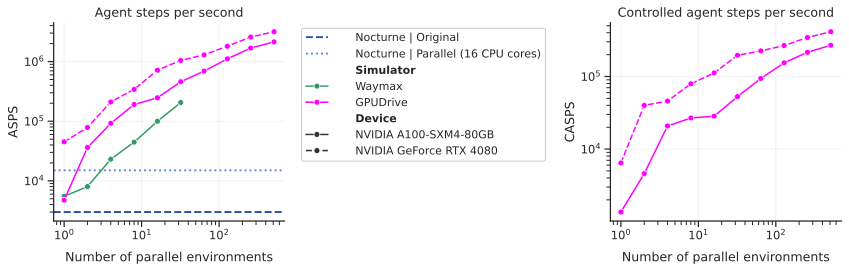

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

axs[0].axhline(y=3000, color=NOCTURNE_COLOR, linestyle='--', alpha=1, label='Nocturne | Original', lw=1.9)
axs[0].axhline(y=15_000, color=NOCTURNE_PUFFERLIB_COLOR, linestyle='dotted', alpha=1, label='Nocturne | Parallel (16 CPU cores)', lw=1.9)

axs[1].set_title(r'Controlled agent steps per second')
sns.lineplot(data=df_all, x='batch_size (num envs)', palette=[GPUDRIVE_COLOR], y='cont_agent_fps', style='Device', hue='Simulator', marker='.', markersize=MARKERSIZE, legend=False, ax=axs[1])

axs[0].set_title(r'Agent steps per second')
sns.lineplot(data=df_all, x='batch_size (num envs)', palette=[WAYMAX_COLOR, GPUDRIVE_COLOR], y='val_agent_fps (goodput)', style='Device', hue='Simulator', marker='.', markersize=MARKERSIZE, ax=axs[0])

axs[0].grid(True, alpha=ALPHA)
axs[1].grid(True, alpha=ALPHA)
axs[0].set_xlabel('Number of parallel environments', labelpad=10)
axs[1].set_xlabel('Number of parallel environments', labelpad=10)
axs[1].set_ylabel('CASPS')
axs[0].set_ylabel('ASPS')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

legend = axs[0].legend(facecolor='white', framealpha=1, fontsize=11, handletextpad=2.5, bbox_to_anchor=(1.05, 1))
for text in legend.get_texts():
    if text.get_text() in ["Device", "Simulator"]:
        text.set_fontweight('bold')

plt.tight_layout()
sns.despine()

plt.savefig(f'raw_sim_speed_log_log.pdf', bbox_inches="tight")

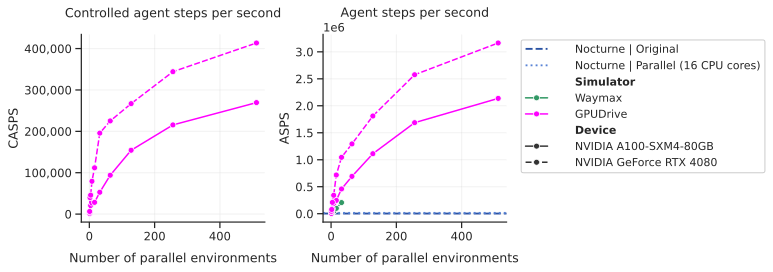

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharex=False)

axs[1].axhline(y=3000, color=NOCTURNE_COLOR, linestyle='--', alpha=1, label='Nocturne | Original', lw=1.9)
axs[1].axhline(y=15_000, color=NOCTURNE_PUFFERLIB_COLOR, linestyle='dotted', alpha=1, label='Nocturne | Parallel (16 CPU cores)', lw=1.9)

axs[0].set_title(r'Controlled agent steps per second', y=1.06)
sns.lineplot(data=df_all, x='batch_size (num envs)', palette=[GPUDRIVE_COLOR], y='cont_agent_fps', style='Device', hue='Simulator', marker='.', markersize=MARKERSIZE, legend=False, ax=axs[0])

axs[1].set_title(r'Agent steps per second')
sns.lineplot(data=df_all, x='batch_size (num envs)', palette=[WAYMAX_COLOR, GPUDRIVE_COLOR], y='val_agent_fps (goodput)', style='Device', hue='Simulator', marker='.', markersize=MARKERSIZE, ax=axs[1])

axs[0].grid(True, alpha=ALPHA)
axs[1].grid(True, alpha=ALPHA)


axs[0].set_xlabel('Number of parallel environments', labelpad=10)
axs[1].set_xlabel('Number of parallel environments', labelpad=10)
axs[0].set_ylabel('CASPS')
axs[1].set_ylabel('ASPS')


axs[0].get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

legend = axs[1].legend(facecolor='white', framealpha=1, fontsize=11, handletextpad=2.5, bbox_to_anchor=(1.05, 1))
for text in legend.get_texts():
    if text.get_text() in ["Device", "Simulator"]:
        text.set_fontweight('bold')

plt.tight_layout()
sns.despine()

plt.savefig(f'raw_sim_speed.pdf', bbox_inches="tight")